# cv

In [ ]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    # NEW
    "torch",
    "mlbench"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

Loading required package: ISLR2

Loading required package: dplyr


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr

Loading required package: readr

Loading required package: purrr

Loading required package: glmnet

Loading required package: Matrix


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loaded glmnet 4.1-8

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: repr

Loading required package: torch

Loading required package: mlbench

  ISLR2   dplyr   tidyr   readr   purrr  glmnet   caret    repr   torch mlbench 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE    TRUE 

## Cross validation

     crim zn indus chas   nox    rm  age    dis rad tax ptratio lstat medv
1 0.00632 18  2.31    0 0.538 6.575 65.2 4.0900   1 296    15.3  4.98 24.0
2 0.02731  0  7.07    0 0.469 6.421 78.9 4.9671   2 242    17.8  9.14 21.6
3 0.02729  0  7.07    0 0.469 7.185 61.1 4.9671   2 242    17.8  4.03 34.7
4 0.03237  0  2.18    0 0.458 6.998 45.8 6.0622   3 222    18.7  2.94 33.4
5 0.06905  0  2.18    0 0.458 7.147 54.2 6.0622   3 222    18.7  5.33 36.2
6 0.02985  0  2.18    0 0.458 6.430 58.7 6.0622   3 222    18.7  5.21 28.7

[1] 506  13

Split the data into training and testing sets

In [ ]:
# randomly sample half of the data


  [1] 203 377 271 151 336 140  87 340 240 143 227 280 423  66 470 224 344 425
 [19] 439 228 130 416 101 499 148 270 250 337 120 383 108  98 415 200 145 241
 [37]  86 134 460 426 481 324 122 328 274 395  63 253 207 477 310 366 176  34
 [55] 131 166  75 459  84 247 428 447 255 502  46 389 418 234 195  99 369 308
 [73]  90 334  61 331 202 233 299 342 249 405 165 100 404 116  58  92 261  42
 [91] 298 472  96 468  83 177 300  64  65 489 125 223 154 192 277  76 471 252
[109] 407 403  29 168 450 410  79 506 267  25 368 268 322 321 284 316 144 156
[127] 158  20 137  71  17 201 346  59  55 466 265 245 315  82 121   7 163 188
[145]  57 325 473  13 442 199 430 296  54 235 285   4 209 313 161 117  11  19
[163] 505 217  28  69 374 287 272 186 243 205  77 132  81 190 204 496  41   5
[181] 475 139 453   3 146 432 278 184  36 483  24 492  43 312  49 462 406 399
[199] 142 208 478 293 501 362 412 343 445 135 361 302 491 367 311 456 303 435
[217] 180  68 262 229 365 232  14 273 105 251 109 198 479  18 26

[1] 0


Call:
lm(formula = medv ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2410 -2.9861 -0.5769  1.7680 26.2469 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  35.948703   7.436949   4.834 2.39e-06 ***
crim         -0.115820   0.043952  -2.635 0.008957 ** 
zn            0.062357   0.022810   2.734 0.006727 ** 
indus         0.034325   0.088138   0.389 0.697289    
chas          5.537246   1.235382   4.482 1.14e-05 ***
nox         -21.494815   6.125044  -3.509 0.000536 ***
rm            4.300990   0.697534   6.166 2.94e-09 ***
age          -0.001252   0.019692  -0.064 0.949345    
dis          -1.536217   0.299013  -5.138 5.76e-07 ***
rad           0.235743   0.110289   2.138 0.033568 *  
tax          -0.010254   0.006114  -1.677 0.094810 .  
ptratio      -0.845825   0.194991  -4.338 2.12e-05 ***
lstat        -0.497500   0.078311  -6.353 1.05e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual 

[1] 21.81484

## k-Fold Cross Validation

 [1] 10  7  5  4  3  1 12  2  8 11  6  9

 [1]  8 11 10  1  2  6  3  6 11  1  6  6

  [1] 5 5 4 5 5 1 3 1 4 1 1 1 1 2 3 2 2 1 3 4 2 1 4 5 2 2 1 5 1 1 1 3 2 1 2 5 3
 [38] 3 1 4 4 4 2 4 2 3 4 5 4 4 3 4 1 3 3 4 4 4 1 2 5 3 4 2 3 3 5 4 1 1 3 3 3 4
 [75] 2 1 5 1 2 3 4 3 2 2 2 5 1 2 1 5 3 1 4 3 4 4 3 1 5 5 1 5 3 3 5 5 1 5 2 4 3
[112] 3 2 1 5 2 2 1 5 4 1 3 1 2 2 1 2 4 5 1 1 3 3 3 5 2 3 2 2 4 4 5 1 3 5 1 5 4
[149] 4 5 4 2 4 5 2 3 3 1 3 1 1 5 4 5 5 1 5 4 1 5 5 2 4 4 2 2 4 2 3 2 1 3 2 4 1
[186] 5 5 2 5 5 4 3 2 2 1 5 5 5 5 5 4 1 5 4 3 1 3 1 1 1 1 5 4 5 1 5 3 3 2 5 4 4
[223] 4 2 2 5 4 1 2 3 5 4 3 1 4 5 3 4 3 2 1 3 2 2 4 2 3 5 3 4 3 4 2 1 3 4 1 3 5
[260] 1 3 2 2 4 4 2 1 5 1 2 3 5 4 5 5 2 5 5 5 5 3 1 5 3 3 3 2 1 1 3 3 3 5 1 4 1
[297] 1 4 2 5 5 5 2 2 3 5 2 1 4 3 4 4 5 3 3 2 1 3 1 4 5 4 1 5 1 1 4 1 2 4 5 3 4
[334] 4 4 2 5 1 4 4 1 3 1 3 1 2 1 3 1 1 4 1 2 5 3 2 5 3 1 2 4 2 4 3 5 2 2 4 4 2
[371] 4 5 3 5 1 3 3 5 4 3 4 5 4 4 2 2 4 4 3 3 4 4 2 1 5 3 1 4 1 2 3 3 1 1 4 2 3
[408] 2 1 4 2 4 3 4 1 5 4 4 1 4 1 2 4 1 5 2 1 2 4 3 1 2 2 5 3 5 3 5 4 5 3 2 5 5
[445] 1 2 4 3 1 2 3 1 4 3 2 3 5 2 5 4 3 

[1] 0

[1] 8

[1] 20.07403 19.60952 24.53778 26.29882 32.21119

## Wrapped in a function

[1] 24.54627

[1] 85.12845

### Using the`caret` package

Define the training control for cross validation


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.1304  -2.7673  -0.5814   1.9414  26.2526 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  41.617270   4.936039   8.431 3.79e-16 ***
crim         -0.121389   0.033000  -3.678 0.000261 ***
zn            0.046963   0.013879   3.384 0.000772 ***
indus         0.013468   0.062145   0.217 0.828520    
chas          2.839993   0.870007   3.264 0.001173 ** 
nox         -18.758022   3.851355  -4.870 1.50e-06 ***
rm            3.658119   0.420246   8.705  < 2e-16 ***
age           0.003611   0.013329   0.271 0.786595    
dis          -1.490754   0.201623  -7.394 6.17e-13 ***
rad           0.289405   0.066908   4.325 1.84e-05 ***
tax          -0.012682   0.003801  -3.337 0.000912 ***
ptratio      -0.937533   0.132206  -7.091 4.63e-12 ***
lstat        -0.552019   0.050659 -10.897  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 

### `caret` for LASSO

#### Bias-variance tradeoff

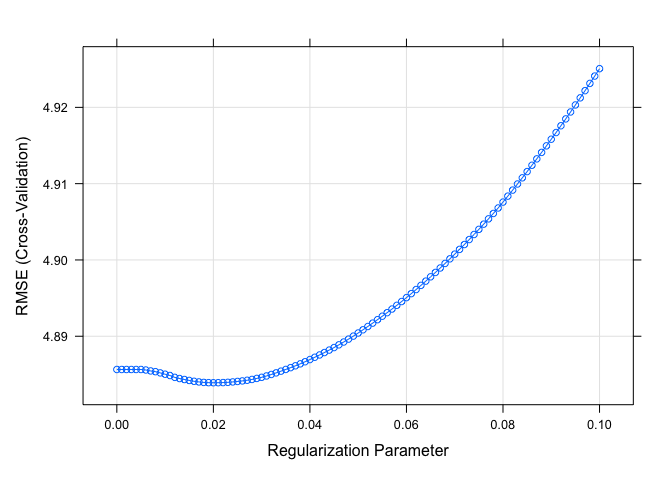